# SVM with the Pegasos algorithm

In [24]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt


def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review


def read_data(file):
    '''
    Read each file into a list of strings.
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on',
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    return list(words)


def load_and_shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = "/Users/alexherron/Documents/GitHub/Machine_Learning/data/pos"
    neg_path = "/Users/alexherron/Documents/GitHub/Machine_Learning/data/neg"

    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)

    review = pos_review + neg_review
    random.shuffle(review)
    return review


def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

    
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

In [7]:
#Bag of words
from collections import Counter

#Use counter function to create dictionary
def bag_of_words(review):
    return dict(Counter(review))

#Call function to return data from files
data = load_and_shuffle_data()

#Gather bag of words for reviews, split into test and train
X = [bag_of_words(review) for review in data]
X_train = X[:1500]
X_test = X[1500:]

#Gather labels, split into test and train
y = [word[-1] for word in data]
y_train = y[:1500]
y_test = y[1500:]

#Confirm correct lengths
print(f"Number of training examples: {len(X_train)}")
print(f"Number of validation examples: {len(X_test)}")

Number of training examples: 1500
Number of validation examples: 500


In [12]:
#Pegasos algorithm
import time

def pegasos(X, y, num_epochs, lambda_reg = 0.1):
    #Set t, epoch equal to zero, make empty dictionary for w
    t = 0
    epoch = 0
    w = {}
    
    #While termination condition not met
    while epoch <= num_epochs:
        #Calculate start time
        time_start = time.time()       
        #Ensure data is randomly permuted
        rand = np.random.RandomState(seed = epoch).permutation(len(X))
        #increment t, calculate eta
        t = t + 1
        eta = 1 / (t * lambda_reg)
        
        #Loop through all values in permuted data
        for i in rand:
            #Determine if y_j*w_t^T*x_j < 1
            if y[i] * dotProduct(w, X[i]) < 1:
                for key, values in X[i].items():
                    #Calculate w_t+1
                    w[key] = (1 - eta * lambda_reg) * w.get(key, 0) + eta * y[i] * values   
            #Otherwise, if if y_j*w_t^T*x_j >= 1
            else:
                for key, values in X[i].items():
                    #Calculate w_t+1
                    w[key] = (1 - eta * lambda_reg) * w.get(key, 0)
        
        #Calculate and print time for a given epoch
        time_stop = time.time()
        #print("Time for epoch " + str(epoch) + ": " + str(time_stop-time_start))
        #Increment epoch
        epoch += 1
        #Return w for final epoch
        if epoch == num_epochs:
            return w

In [13]:
#Accelerated Pegasos algorithm

def pegasos_accel(X, y, num_epochs, lambda_reg):
    #Set t to 1, epoch to zero, make empty dictionary for w
    t = 1
    epoch = 0
    w = {}
    #Calculate length of X and its indices
    total_num = len(X)
    index = np.arange(total_num)
    #Set s to 1, create empty dictionary for w_i
    s = 1
    w_i = {}
    
    #Loop through each epoch
    for i in range(num_epochs):
        #Initialize time
        time_start = time.time()        
        
        #Loop through each index
        for j in index:
            #Add to t, update eta and s
            t += 1
            eta = 1 / (t * lambda_reg)
            s = s * (1 - eta * lambda_reg)
            
            #Increment if condition satisfied
            if y[j] * dotProduct(X[j], w) < (1 / s):
                increment(w, (1 / s) * eta * y[j], X[j])
        
        #Reset w_i, then increment
        w_i = {}
        increment(w_i, s, w)
        #Calculate and print time for each epoch
        time_stop = time.time()
        #print("Time for epoch " + str(i) + ": " + str(time_stop-time_start))
    return w_i

In [17]:
#Comparison of default and accelerated Pegasos
num_epochs = 3
lambda_i = 0.11
value = 1
w_pegasos = pegasos(X_train, y_train, num_epochs, lambda_i)
print(f"Default Pegasos: {w_pegasos[value]}")

w_pegasos_accel = pegasos_accel(X_train, y_train, num_epochs, lambda_i)
print(f"Accelerated Pegasos: {w_pegasos_accel[value]}")

Default Pegasos: 2.113824808234568
Accelerated Pegasos: 1.185595120276295


In [19]:
#Example of accelerated Pegasos speed

word = 'follows'
print(f"word: {word}")
print(f"Default Pegasos: {w_pegasos[word]}")
print(f"Accelerated Pegasos: {w_pegasos_accel[word]}")

word: follows
Default Pegasos: 0.969616164980069
Accelerated Pegasos: 0.0383753105370523


In [21]:
#Classification error function

def classification_error(w, X, y):
    #Initialize count, set total number of labels
    total_num = len(y)
    correct = 0
    
    #Unzip, calculated predicted y values, set labels
    for X, y in zip(X, y):
        y_predicted = dotProduct(w, X)
        label = y
    
        #Compare predicted values and actual labels
        if y_predicted >= 0:
            y_pred_i = 1
        else:
            y_pred_i = -1
        if label == y_pred_i:
            correct += 1
            
    #Calculate error
    correct_fraction = correct / total_num
    error = 1 - correct_fraction
    
    #Return error
    return error

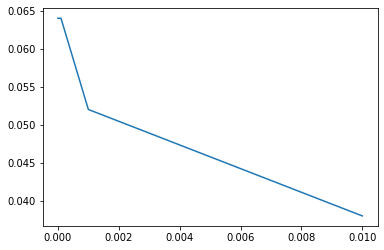

In [25]:
# Gather errors and plot

lambda_list = 10.**np.arange(-10, -1)
w_list = []
error_list = []
num_epochs = 50

for lambda_i in lambda_list:
    w_i = pegasos_accel(X_train, y_train, num_epochs, lambda_reg = lambda_i)
    w_list.append(w_i)
    error_list.append(classification_error(w_i, X_test, y_test))
    
plt.plot(lambda_list, error_list)

In [26]:
#Find optimal regularization parameter for accelerated pegasos

lambda_list = 10.**np.arange(-10, -1)
w_list = []
error_list = []
num_epochs = 100

for lambda_i in lambda_list:
    w_i = pegasos_accel(X_train, y_train, num_epochs, lambda_reg = lambda_i)
    w_list.append(w_i)
    error_list.append(classification_error(w_i, X_test, y_test))

Number of epochs: 100
Optimal lambda value: 0.001


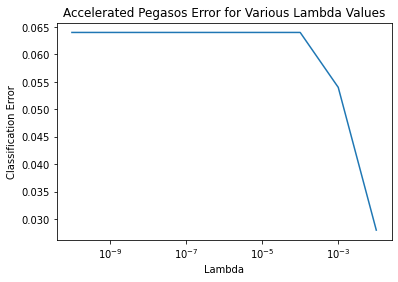

In [27]:
plt.plot(lambda_list, error_list)
plt.title('Accelerated Pegasos Error for Various Lambda Values')
plt.xlabel('Lambda')
plt.ylabel('Classification Error')
plt.xscale('log')
print(f"Number of epochs: {num_epochs}")
print(f"Optimal lambda value: {1e-3}")

# Kernels

### Kernels and Kernel Machines

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools
from scipy.spatial.distance import cdist

%matplotlib inline

In [29]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
#21. Functions for RBF kernel and polynomial kernel
    
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    #TODO
    distance = cdist(X1, X2, 'sqeuclidean')
    rbf_kernel = np.exp(-((distance)/(2 * sigma **2)))
    return rbf_kernel
 
def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    #TODO
    poly_kernel = (linear_kernel(X1, X2) + offset) ** degree
    return poly_kernel

In [30]:
#Compute kernel matrix on given set

x_0 = [[-4], [-1], [0], [2]]
linear_kernel(x_0, x_0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

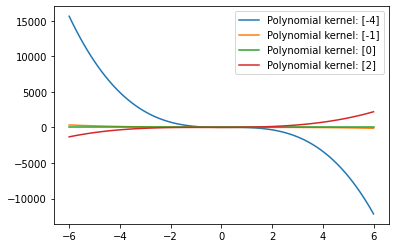

In [31]:
#Plot set of functions for polynomial kernel

#Set values for x_0 according to instructions
x_0 = np.array([-4,-1,0,2]).reshape(-1,1)

#x values are in [-6, 6]
step = 0.1
x_range = np.arange(-6.0, 6.1, step).reshape(-1,1)

#Set offset and degree values according to instructions
offset = 1
degree = 3

#Calculate polynomial kernel for each value
y = polynomial_kernel(x_0, x_range, offset, degree)

#Plot each function
for i in range(len(x_0)):
    label_i = "Polynomial kernel: " + str(x_0[i])
    plt.plot(x_range, y[i,:], label = label_i)
plt.legend()
plt.show()

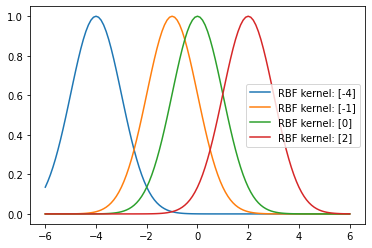

In [32]:
#Plot set of functions for RBF kernel

#Calculate RBF kernel for each value for given sigma
sigma = 1
y = RBF_kernel(x_0, x_range, sigma)

#Plot each function
for i in range(len(x_0)):
    label_i = "RBF kernel: " + str(x_0[i])
    plt.plot(x_range, y[i,:], label = label_i)
plt.legend()
plt.show()

In [33]:
#Complete prediction function of the class Kernel_Machine
#Construct a Kernel_Machine object, plot the resulting function

#Skeleton code
class Kernel_Machine(object):
    def __init__(self, kernel, training_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            training_points - an nxd matrix with rows x_1,..., x_n
            weights - a vector of length n with entries alpha_1,...,alpha_n
        """

        self.kernel = kernel
        self.training_points = training_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R alpha_i k(x_j, mu_i)
        """
        # TODO
        self_kernel = self.kernel(X, self.training_points)
        evals = np.dot(self_kernel, self.weights)
        return evals

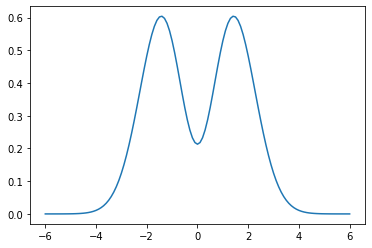

In [34]:
#Construct a Kernel_Machine object, plot the resulting function

#Use partial application for kernel functions
from functools import partial

#Set points and weights
points = np.array([-1,0,1]).reshape(-1,1)
weights = np.array([1,-1,1]).reshape(-1,1)

#Use partial to help calculate kernel machine and predict x
np.array([-4, -1, 0, 2]).reshape(-1,1)
k = partial(RBF_kernel, sigma = 1)
km = Kernel_Machine(k, points, weights)

#Plot resulting function
plt.plot(x_range, km.predict(x_range))

### Kernel Ridge Regression: Practice

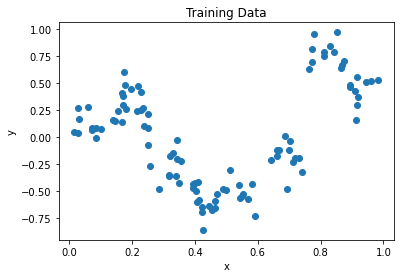

In [38]:
#Plot the training data
train = np.loadtxt("krr-train.txt")
test = np.loadtxt("krr-test.txt")

#Separate x and y data for train & test
x_train = train[:,0].reshape(-1,1)
y_train = train[:,1].reshape(-1,1)
x_test = test[:,0].reshape(-1,1)
y_test = test[:,1].reshape(-1,1)

#Plot
plt.scatter(x_train, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data')
plt.show()

In [39]:
#Complete train_kernel_ridge_regression function

def train_kernel_ridge_regression(X, y, kernel, l2reg):
    #Find kernel and it's dimensions
    kernel_x = kernel(X, X)
    kernel_x_dim = kernel_x.shape[0]
    
    #Calculate alpha, use for kernel machine call, return kernel machine
    alpha = np.linalg.inv((np.identity(kernel_x_dim) * l2reg + kernel_x)).dot(y)
    km = Kernel_Machine(kernel, X, alpha)
    return km

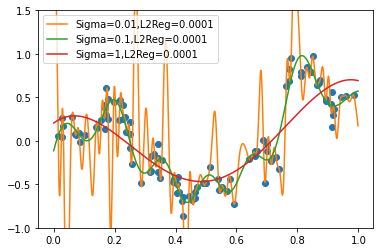

In [40]:
#Plot various sigma values for fixed lambda

plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

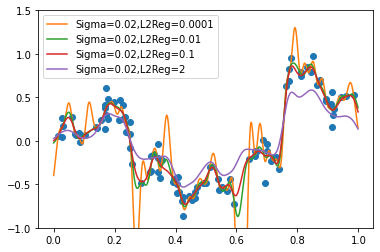

In [41]:
#Plot various lambda values for fixed sigma

#Provided code
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, kernel = k, l2reg = l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()